# 첫 번째 심층 신경망

## 라이브러리 임포트

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Flatten, Dense, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.datasets import cifar10
# 6만개의 이미지로 구성되어 있고 각 이미지는 10개의 클래스 중 하나로 분류되어 있음

## 데이터 적재

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# numpy 배열
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [3]:
NUM_CLASSES = 10

In [4]:
# 기본적으로 이미지 데이터는 픽셀 채널마다 0~255 사이의 정수로 구성됨
# 신경망은 입력이 -1~1 사이 범위에 놓여 있을 때 가장 잘 동작하기 때문에 데이터를 255로 나눔
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

# 이미지의 정수 레이블을 원핫인코딩 벡터로 바꿈
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [6]:
# 첫번째 차원 : 데이터셋에 있는 이미지의 인덱스
# 두번째 차원 : 이미지의 높이
# 세번째 차원 : 이미지의 너비
# 네번째 차원 : 컬러 채널(RGB이미지이므로 빨강, 초록, 파랑)  => 4차원 텐서

# 인덱스 54 이미지에서 (12,13) 위치에 해당하는 픽셀의 초록 채널(1) 값을 의미함
print(X_train[54, 12, 13, 1])

print(X_train.shape)

0.36862746
(50000, 32, 32, 3)


## 모델 만들기

In [ ]:
# Sequential 모델을 사용한 네트워크
# 일렬로 층을 쌓은 네트워크를 빠르게 만들 때 사용하기 좋음

model = Sequential([
    Dense(200, activation='relu', input_shape=(32,32,3)),
    Flatten(),
    Dense(150, activation='relu'),
    Dense(10, activation='softmax')
])

In [8]:
# 함수형 API(Model)를 사용한 네트워크
# 한 층이 여러개의 별도의 층으로 전달되거나 한 층이 여러 층으로부터 입력 받을때 사용하기 좋음. 유연성

# Input층 : 네트워크의 시작점. 입력 데이터 크기를 튜플로 알려주어야함. batch_size 지정하지 않음.
    # Input 층에 임의의 이미지 개수를 전달할 수 있기 때문에 batch_size는 필요하지 않음
    # Input 층의 크기는 X_train과 맞아야 함
input_layer = Input(shape=(32,32,3))

# Flatten층 : 입력을 하나의 벡터로 펼침 >> 결과 벡터의 길이 : 32 x 32 x 3 = 3072
    # 뒤따르는 Dense 층이 다차원 배열이 아니라 평평한 입력을 기대하기 때문
x = Flatten()(input_layer)

# Dense 층 : 이전 층과 완전하게 연결되는 유닛을 가지고 있음. 연결마다 하나의(양수 또는 음수인) 가중치가 동반됨
    # 유닛의 출력은 이전 층으로부터 받은 입려과 가중치를 곱하여 더한 것
    # 비선형 활성화 함수를 통과하고 다음 층으로 전달됨 
x = Dense(units=200, activation='relu')(x)
x = Dense(units=150, activation='relu')(x)

# 마지막 출력 Dense 층의 크기는 y_train과 맞아야함
output_layer = Dense(units=10, activation='softmax')(x)

model = Model(input_layer, output_layer)

In [9]:
# 케라스는 None을 사용하여 아직 네트워크에 전달될 샘플의 개수를 모른다는 것을 표시함. 지정할 필요 없음
    # 텐서 연산은 선형 대수를 사용해 동시에 모든 샘플에 수행됨

# Parma # : 각 층에서 훈련될 파라미터(가중치)의 수
    # 모델이 너무 느리게 훈련된다면 너무 많은 가중치가 있는 층을 확인하여 유닛의 개수를 줄여서 속도를 높일 수 있음
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 200)               614600    
                                                                 
 dense_4 (Dense)             (None, 150)               30150     
                                                                 
 dense_5 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


## 모델 컴파일

In [11]:
# 모델에 손실함수(loss function)와 옵티마이저(optimizer)를 연결함
    # 손실 함수 : 신경망이 예측 출력과 정답을 비교하는데 사용됨. 샘플마다 하나의 수치를 반환함. 이 값이 클수록 결과 좋지 않은 것
    # 가장 많이 사용하는 손실함수
        # mean squared error(평균 제곱 오차) : 회귀문제(연속적인 값 예측)에 주로 사용
        # categorical_crossentropy(범주형 크로스엔트로피) : 여러 클래스 중 하나에 속해야하는 분류 문제
        # binary_crossentropy(이진 크로스엔트로피) : 하나의 출력 유닛을 가진 이진분류 문제 or 샘플이 여러 개의 클래스에 속할 수 있는 다중 레이블 문제

# 옵티마이저 : 손실 함수의 그레이디언트를 기반으로 신경망의 가중치를 업데이트하기 위해 사용
    # 학습률이 클수록 한번의 훈련 스텝에서 가중치를 크게 바꿈
    # 학습률이 크면 초기에 훈련 속도가 빠르지만 훈련이 불안정한 담점이 있음.
    # Adam 외에 널리 사용하는 다른 옵티마이저는 RMSProp (매개변수 이해 필요함)
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## 모델 훈련

In [13]:
# 1. 네트워크의 가중치를 작고 랜덤한 수로 초기화한 뒤 연속 된 훈련 스텝 수행
# 2. 훈련 스텝마다 배치사이즈의 갯수로 할당된 이미지가 한 이미지 배치가되고 네트워크를 통과하고 오차가 역전파되어 가중치를 업데이트함
    # - 배치 크기가 클수록 가중치를 업데이트하는 계산은 안정적이지만 각 훈련 스텝의 속도는 느려짐
    # - 일반적으로 32에서 256사이의 배치 크기를 사용함. 요즘엔 훈련이 진행됨에 따라 배치 크기를 증가시키는 것이 권장됨
# 3. 위의 과정이 데이터셋의 모든 샘플이 사용될 때까지 계속됨.이것이 완료되면 첫 번째 에폭이 됨
# 4. 데이터는 이제 다시 두번째 에폭을 위해 뱇 ㅣ로 나뉘어 네트워크에 전달됨 >> 지정한 횟수의 에폭만큼 1~4번 계속 반복

with tf.device('/GPU:0'):
    model.fit(X_train,  # 원본 이미지 데이터
             y_train,  # 원-핫 인코딩된 클래스 레이블
             batch_size = 32,  # batch_size : 훈련 스텝마다 네트워크에 전달될 샘플의 개수를 결정
             epochs = 10,  # epochs : 네트워크가 전체 훈련 데이터에 대해 반복하여 훈련할 횟수
             shuffle = True  # shuffle = True : 훈련 스텝마다 배치를 훈련 데이터에서 중복을 허용하지 않고 랜덤하게 추출
             )

Epoch 1/10
1563/1563 [==============================] - 7s 3ms/step - loss: 1.8393 - accuracy: 0.3389
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6536 - accuracy: 0.4073
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5747 - accuracy: 0.4402
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5260 - accuracy: 0.4577
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.4865 - accuracy: 0.4696
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.4565 - accuracy: 0.4796
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.4304 - accuracy: 0.4905
Epoch 8/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.4097 - accuracy: 0.4998
Epoch 9/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.3850 - accuracy: 0.5089
Epoch 10/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.365

## 모델 평가

In [14]:
# 모델이 훈련 세트에서는 51.3% 정확도를 달성했음. 본적 없는 데이터에서의 성능을 측정해야함
model.evaluate(X_test, y_test)
    # 본적 없는 이미지에서도 48%의 정확도를 달성함

313/313 [==============================] - 1s 3ms/step - loss: 1.4589 - accuracy: 0.4828


[1.4589048624038696, 0.4828000068664551]

In [15]:
# predict : 테스트 세트에 대한 예측 결과 확인해보기
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# np.argmax() : 최대값에 해당하는 index 값 찾기
preds = model.predict(X_test)  # preds는 [10000,10] 크기의 배열. 10000개의 샘플마다 10개의 클래스 확률을 담은 벡터
preds_single = CLASSES[np.argmax(preds, axis = -1)]  # argmax 함수를 사용해 예측 결과로 바꿈. axis = -1 : 클래스(마지막) 차원으로 배열을 압축하라는 뜻. 크기 : [10000, 1]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

313/313 [==============================] - 0s 1ms/step


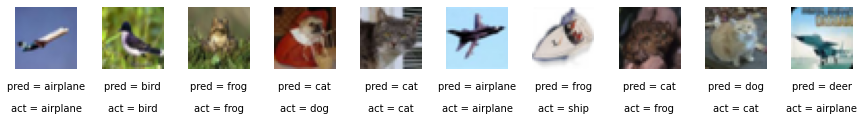

In [16]:
# 이미지와 예측값, 실제 레이블 출력하기
# np.random.choice(A,B) : 0부터 A까지 수 중에서 B개 랜덤으로 뽑기

n_to_show = 10
indices = np.random.choice(range(len(X_test)),n_to_show)

fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i, idx in enumerate(indices):
    img = X_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)